# Phase-Aware Steady-State Detection

We wish to find representative regions of simulation and replace those regions with a statistical model to reduce the computational cost of simulation.

This notebook demonstrates two things: 
1. How do we find phases?
2. How do we determine onwhence we have completed any warm-up associated with the phase?

In [1]:
# Built-in modules
import os
import sys
import time
import statistics
from dataclasses import dataclass

# External modules
import scipy
import numpy as np
import pandas as pd
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from bokeh.palettes import Pastel1

# Local modules
from Window import Window
from Mapper import Mapper
from Trace  import TraceList

In [2]:
DATA_DIR = 'parrot-traces/medium-100ms-manualpd/'

In [3]:
TRACES = TraceList(DATA_DIR)

In [4]:
print('Directory:'.ljust(10), DATA_DIR)
print('Files:'.ljust(10), TRACES)

Directory: parrot-traces/medium-100ms-manualpd/
Files:     2mm 3mm adi atax bicg cholesky correlation covariance deriche doitgen durbin fdtd-2d floyd-warshall gemm gemver gesummv gramschmidt heat-3d jacobi-1d jacobi-2d lu ludcmp mvt nussinov seidel-2d symm syr2k syrk trisolv trmm


In [5]:
%%time
TRACES.load() # Load the traces into memory. Optional. Skip if all traces can't fit into memory at once

CPU times: user 4min 48s, sys: 42.6 s, total: 5min 31s
Wall time: 5min 31s


In [6]:
@jit
def get_phase_changes(phases):
    pc = []
    for i in range(len(phases)-1):
        if phases[i] != phases[i+1]:
            pc.append(i)
    return pc

def reformat_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
@jit
def get_phase_changes(arr, interval_len):
    marker = 0
    #changes = {0:arr[0]}
    intervals = []
    for i in range(len(arr)-1):
        if arr[i] != arr[i+1]:
            intervals.append([marker, i//interval_len, arr[i]])
            marker = i//interval_len
    intervals.append([marker, i//interval_len, arr[-1]])
    return intervals    

def latency_phase_plot(ax, t, interval_len):

    # Get latency data
    df = t.load(persist=True)
    series = df['latency_nano']

    # We will average over intervals. Calculate how many intervals of size interval_len there are
    nintervals = len(series)//interval_len
    peri = [np.mean(series[i*interval_len : (i+1)*interval_len]) for i in range(nintervals)]
    
    # Plot
    ax.plot(peri, color='black', markersize=1)
    
    # Add benchmark name
    ax.text(nintervals//2, 15, t.name, ha='center')
    
    # Formatting
    reformat_ax(ax)
    ax.set_xticks([nintervals//2, nintervals])

    
    # Add background patches for each interval
    color = Pastel1[9]
    intervals = get_phase_changes(np.array(df['phase']), interval_len)
    for start, end, phase in intervals:
        rectangle = matplotlib.patches.Rectangle((start, 0), end - start, 15, facecolor=color[phase%len(color)])
        ax.add_patch(rectangle)

In [7]:
def plot_all(traces, plotter, param, suptitle, filename=None):
    mapper = Mapper(len(traces)) 
    fig = mapper.fig
    
    for i, t in enumerate(traces):
        plotter(mapper[i], t, param)
        
    fig.set_size_inches((3*mapper.smallest_sq, 2*mapper.smallest_sq))
    fig.patch.set_facecolor('white')
    fig.suptitle(suptitle)
    if filename is not None:
        fig.savefig(filename)
    plt.show()

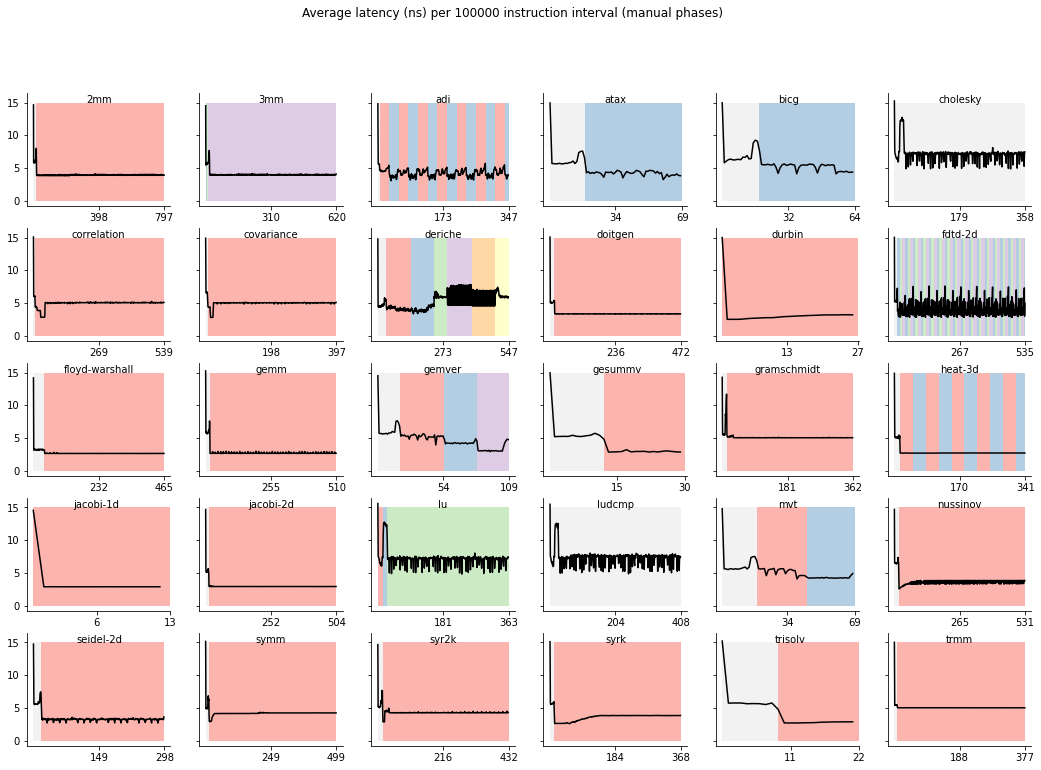

In [8]:
interval_len = 100000
title = f'Average latency (ns) per {interval_len} instruction interval (manual phases)'
plot_all(TRACES, latency_phase_plot, interval_len, title)

In [9]:
%%time
aa = np.array(TRACES[0].load()['phase'])
print(get_phase_changes(aa, interval_len))

[[0, 18, -1], [18, 797, 0]]
CPU times: user 393 ms, sys: 118 ms, total: 511 ms
Wall time: 511 ms


# The F-t-Pj-RG Method

This method was developed by researchers at Virginia Tech and ORNL to detect when Kinetic Monte Carlo simulations had reached a steady state. They want to be able to determine if they have simulated for long enough to end the simulation.

Their method applies three three statistical tests to determine if a steady state has been reached:
- An F-test determines if the variance of two consecutive windows is equal.
- A t-test determines if the mean of two consecutive windows is equal.
- A projection test determines if slope of the data in the windows can predict the data for future intervals

If any one of the tests fails, the windows are "Rolled," meaning they are shifted forwards, and they are "Grown," by a number of datapoints. 

The nice thing about this method is that you get both
1. A time step at which the steady state is a achieved and
1. A region with representative statistics.

## Parameters

The authors state that the most important thing for users to define what a steady state means for their application. This is defined by the projection distance (`proj_dist` in this code, `x_star` in their pseudo-code) and the passing threshold (`proj_delta` here, `delta_y_pass` in their pseudo-code)

In [18]:
# A class for holding all of the parameters needed for the F-t-Pj-RG method
@dataclass(frozen=True)
class FTPJ: 
    # High-level parameters
    window_start:  int = 1000
    summarize:     int = 1000
    ms_init:       int = 10
    debug:         bool = False
    disp_interval: int = 100000
    
    # F-test parameters
    f_conf:  float = 0.05
    f_shift: int = 1
    f_grow:  int = 1
        
    # t-test parameters
    t_conf:  float = 0.05
    t_shift: int = 1
    t_grow:  int = 1
    
    # Projection test parameters
    proj_dist:  int = 5
    proj_delta: int = 1
    p_shift:    int = 1
    p_grow:     int = 1

In [11]:
def f_test(group1, group2) -> (np.float64, np.float64):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size-1
    dun = group2.size-1
    p_value = 1-scipy.stats.f.cdf(f, nun, dun)
    return f, p_value

In [12]:
def ftPjRG2(df, params, extents = None):
    
    params = FTPJ()
    
    if extents is not None:
        latency = latency = np.array(df.load()['latency_nano'][extents[0]:extents[1]], dtype=np.int64)
    else:
        latency = np.array(df.load()['latency_nano'], dtype=np.int64)
    
    new_len = len(latency) // params.summarize
    latency_summarized = np.array([np.mean(latency[i*params.summarize : (i+1)*params.summarize]) for i in range(new_len)])
    win = Window(latency_summarized, size=params.window_start)
    
    win0 = None
    win1 = None
    ms  = params.ms_init
    _phase = 1
    
    while(True):
        if _phase == 1:
            
            if params.debug:
                print('Phase 1!')
                
            # Update windows
            win0 = win.get(0)
            win1 = win.get(1)
        
            # If we have gone past the end of the input array, then we never reached a steady state
            if win0 is None or win1 is None:
                if params.debug:
                    print('Never converged!')
                return None
        
            # F-test
            # Null hypothesis: windows have same variance
            # Reject null: windows have different variance
            f_val, f_pv = f_test(win0, win1)
            if f_pv < params.f_conf: 
                win.shift_and_grow(params.f_shift, params.f_grow)
                
                if win.size < ms*params.window_start:
                    continue
                else:
                    win.shift_and_reset(params.f_shift, params.window_start)
                    ms = int(ms * g_m)
                    continue # ADDED LINE
            else:
                _phase = 2
                continue
                

        elif _phase == 2:
            
            if params.debug:
                print('Phase 2!')
                
            # Null: windows have same mean
            # Reject: windows have different mean
            t_val, t_pv = scipy.stats.ttest_ind(win0, win1)
            
            if t_val < params.t_conf:
                win.shift_and_grow(params.t_shift, params.t_grow)
                _phase = 1
                continue
            else:
                _phase = 3
                continue

        elif _phase == 3:
            
            if params.debug:
                print('Phase 3!')
                
            win_combo = win.get_range(0, 1)
            
            lm = LinearRegression()
            lm.fit(np.array(range(len(win_combo))).reshape(-1,1), win_combo.reshape(-1, 1))            
            
            ret = win.get_point(params.proj_dist)
            if ret is None:
                if params.debug:
                    print('Never converged: Unable to project far enough to confirm projection test.')
                return None
            x_star, y_true = ret
            y_hat = lm.intercept_ + lm.coef_*x_star
            y_hat = y_hat[0][0]
            
            if np.abs(y_hat - y_true) > params.proj_delta:
                win.shift_and_grow(params.p_shift, params.p_grow)
                _phase = 1
                continue
            
            return win.start, win.size*2
    
        else:
            print(f'Error - phase not recognized {_phase}')
            sys.exit(1)

In [13]:
def ftpjrg_plot(ax, t, params):
    
    new_len = len(t.load()['latency_nano']) // params.summarize
    _ll = t.load()['latency_nano']
    ll = np.array([np.mean(_ll[i*params.summarize : (i+1)*params.summarize]) for i in range(new_len)])
    ax.plot(ll)
    
    reformat_ax(ax)
    ax.text(new_len//2, 60, t.name, ha='center')
    
    ret = ftPjRG2(t, params)
    if ret is None:
        return
    stable, stable_size = ret
    ax.axvline(stable, color='red')
    ax.axvline(stable+stable_size, color='red')
    
    # Phase coloring
    color = Pastel1[9]
    intervals = get_phase_changes(np.array(t.load()['phase']), params.summarize)
    for start, end, phase in intervals:
        rectangle = matplotlib.patches.Rectangle((start, 0), end - start, 60, facecolor=color[phase%len(color)])
        ax.add_patch(rectangle)
    

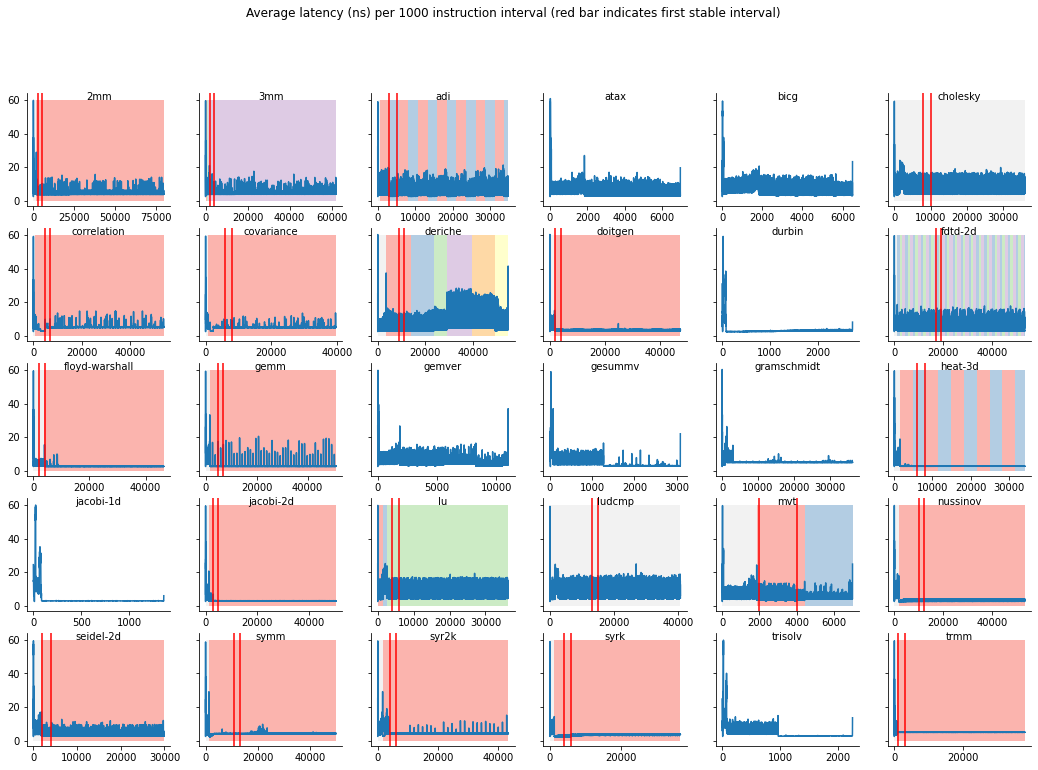

CPU times: user 2min 9s, sys: 9.39 s, total: 2min 18s
Wall time: 2min 11s


In [15]:
%%time
params = FTPJ()
title = f'Average latency (ns) per {params.summarize} instruction interval (red bar indicates first stable interval)'
plot_all(TRACES, ftpjrg_plot, params, title)

In [16]:
def ftpjrg_plot_perphase(ax, t, params):
    
    new_len = len(t.load()['latency_nano']) // params.summarize
    _ll = t.load()['latency_nano']
    ll = np.array([np.mean(_ll[i*params.summarize : (i+1)*params.summarize]) for i in range(new_len)])
    ax.plot(ll)
    
    reformat_ax(ax)
    ax.text(new_len//2, 60, t.name, ha='center')
    
    # Phase coloring
    color = Pastel1[9]
    intervals = get_phase_changes(np.array(t.load()['phase']), params.summarize)
    for start, end, phase in intervals:
        rectangle = matplotlib.patches.Rectangle((start, 0), end - start, 60, facecolor=color[phase%len(color)])
        ax.add_patch(rectangle)
        
    # The intervals calculated for phase colors can be used to find the extents of the first
    # execution of each phase. 
    phases_seen = []
    for start, end, phase in intervals:
        if phase in phases_seen:
            continue
        phases_seen.append(phase)
        
        start = start * params.summarize
        end = end * params.summarize
        ret = ftPjRG2(t, params, extents=(start, end))
        if ret is None:
            continue
        stable, stable_size = ret
        ax.axvline(stable, color='red')
        ax.axvline(stable+stable_size, color='red')
    

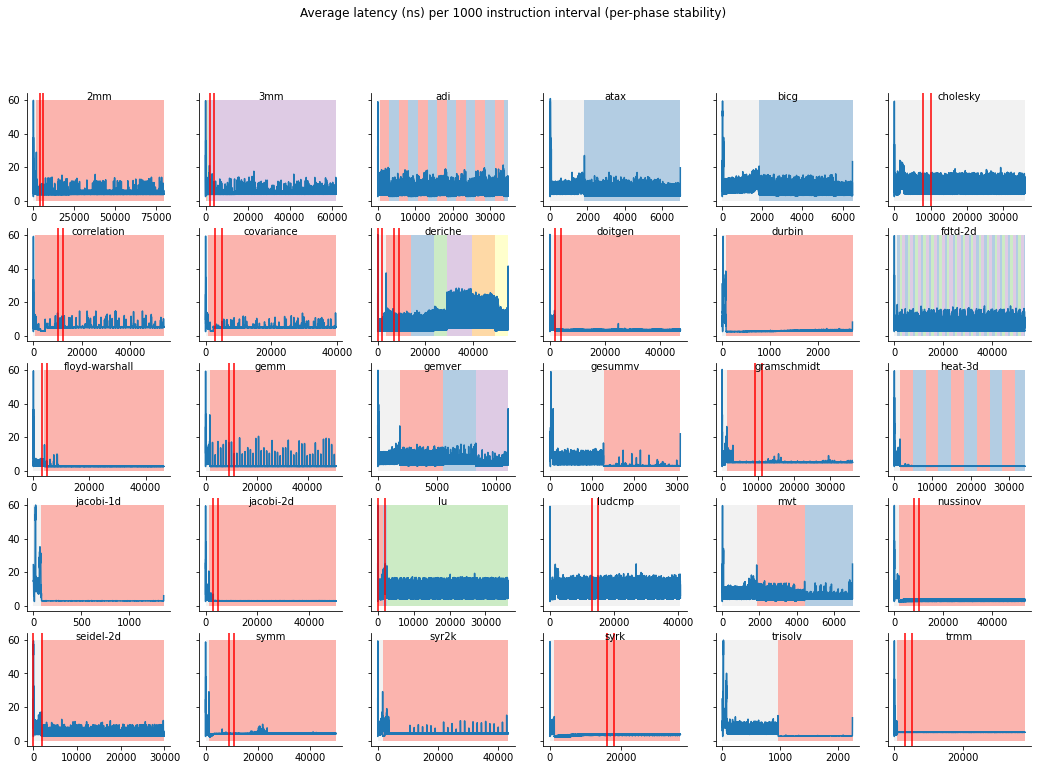

In [17]:
params = FTPJ()
title = f'Average latency (ns) per {params.summarize} instruction interval (per-phase stability)'
plot_all(TRACES, ftpjrg_plot_perphase, params, title)

# Next Steps

1. In python, combine Phase Detection + FtPjRG
1. Tune the FtPjRG parameters a bit
1. Once they work a bit better (e.g. fix jacobi-1d), output the representative regions to a file
which can be read by my simulator. (I.e. hard code the representative region boundaries for now.)
1. Evaluation study (below)

## Multifidelity Simulation Plan

1. Phases identified (manually for now)
2. When a new phase is identified, find a representative region using FtPjRG (also going to be manual at first)
3. For the remainder of the phase, sample from the representative region instead of simulating the memory hierarchy

## Evaluation

1. For the polybench benchmarks, determine if this method has an acceptable accuracy for the same system configuration that we collected the data on. 
2. Test other cache parameters
    - The methodology may need to be added to the simulator for it to work with other system configurations
    - For a full-evaluation, we may need to 
3. Try multi-threaded runs
    - The L2 cache will still be shared
    - Note to self: I need to make sure multiple threads don't send the same phase message